# CBU5201 mini-project submission


## What is the problem?

This year's mini-project considers the problem of predicting whether a narrated story is true or not. Specifically, you will build a machine learning model that takes as an input an audio recording of **3-5 minutes** of duration and predicts whether the story being narrated is **true or not**. 


## Which dataset will I use?

A total of 100 samples consisting of a complete audio recording, a *Language* attribute and a *Story Type* attribute have been made available for you to build your machine learning model. The audio recordings can be downloaded from:

https://github.com/CBU5201Datasets/Deception

A CSV file recording the *Language* attribute and *Story Type* of each audio file can be downloaded from:

https://github.com/CBU5201Datasets/Deception/blob/main/CBU0521DD_stories_attributes.csv




## What will I submit?

Your submission will consist of **one single Jupyter notebook** that should include:

*   **Text cells**, describing in your own words, rigorously and concisely your approach, each implemented step and the results that you obtain,
*   **Code cells**, implementing each step,
*   **Output cells**, i.e. the output from each code cell,

Your notebook **should have the structure** outlined below. Please make sure that you **run all the cells** and that the **output cells are saved** before submission. 

Please save your notebook as:

* CBU5201_miniproject.ipynb


## How will my submission be evaluated?

This submission is worth 16 marks. We will value:

*   Conciseness in your writing.
*   Correctness in your methodology.
*   Correctness in your analysis and conclusions.
*   Completeness.
*   Originality and efforts to try something new.

(4 marks are given based on your audio submission from stage 1.)

**The final performance of your solutions will not influence your grade**. We will grade your understanding. If you have an good understanding, you will be using the right methodology, selecting the right approaches, assessing correctly the quality of your solutions, sometimes acknowledging that despite your attempts your solutions are not good enough, and critically reflecting on your work to suggest what you could have done differently. 

Note that **the problem that we are intending to solve is very difficult**. Do not despair if you do not get good results, **difficulty is precisely what makes it interesting** and **worth trying**. 

## Show the world what you can do 

Why don't you use **GitHub** to manage your project? GitHub can be used as a presentation card that showcases what you have done and gives evidence of your data science skills, knowledge and experience. **Potential employers are always looking for this kind of evidence**. 





------------------------------------ PLEASE USE THE STRUCTURE BELOW THIS LINE ------------------------------------------

# B-FAUTT: The Boosting-led First-AUdio-Then-Text Approach for Deceptive Story Detection

The full code will be made public on GitHub after the deadline at https://github.com/scris/ml-project-fautt.

# 1 Author

**Student Name**: Tianze Qiu

**Student ID**: 221170249



# 2 Problem formulation

## 2.1 Problem

We're given a dataset of audio recordings of stories, both in English and in Chinese, and their corresponding labels of deceptive or not. The task is to build a machine learning pipeline that can predict whether a story is deceptive or not based on the audio recording file.

## 2.2 Why is it interesting?

1. **Real-world application**: The ability to detect deceptive stories has a bunch of real-world applications, for example, in lie detection, fraud detection, fake news detection, etc.
2. **Difficulty of the task**: The task is very challenging because it requires us to think of a way that can work fine in only 100 samples and gain reasonable accuracy.
3. **Potential for creativity**: The task is open-ended and allows for a lot of creativity in the parts of feature engineering, model selection, and evaluation.

# 3 Methodology

Overall, we use a boosting-led approach utilizing cherry-picked first-audio-then-text multimodal features for this detection problem. These tasks below are involved during the procedure:

## 3.1 Preparation

First, we prepare the dataset. We derive a text version from the audio files, then translate and lemmatize it to build a text-based dataset. This dataset is used along the original audio-based one.

## 3.2 Feature Engineering

Audio features are very high-dimensional, and model will be overfitting if original features are given. Also, it will be helpful is model is also assisted with features extracted from text.

These are features used during this process. Their details will be described thoroughly in later sections.

### Audio Features

- [Main] Filter bank features extracted from audio waveform.
- Basic voice characteristics, like energy, zero crossings, kurtosis and skew.
- Silence related features, like silence count, duration, and joint features with things like language.

### Text Features

- [Main] TF-IDF features from lemmatized English text.
- Basic linguistic features, like word count, sentence count, stop words, etc.
- Other features like word richness and repetition ratio.

After manually picking these features, we use a CatBoost model to distinguish the importance of all features. Some least important features are then removed to improve efficiency and eliminate overfitting possibilities.

## 3.3 Train Process

With these features extracted from both modalities, we do binary classification task to detect deceptive stories (label=1) vs truthful stories (label=0).

The 100-sample dataset is split into 76 training and 24 test samples (76/24 split) for best performance. Stratified split is used to maintain class distribution, and Scikit-learn standard scaler is utilized to keep every feature in a uniform scale.

Three different models are used:

- CatBoost: A gradient boosting algorithm optimized for categorical features, known for its high efficiency and performance with minimal hyperparameter tuning.
- Naive Bayes: A probabilistic classifier based on Bayes' theorem, commonly used for its simplicity and effectiveness in text classification tasks, especially when feature independence is assumed.
- K-Nearest Neighbors (KNN): A non-parametric method that classifies samples based on the majority vote of the closest neighbors, with distance as the key metric for classification.

They're stacked as one classifier with a final logistic regression estimator. And this classifier is fitted with the features and labels of the training subset.

## 3.4 Validation Process

We use 5-fold cross validation, and evaluate the performance of the model by these metrics:

- Accuracy: This measures the proportion of correct predictions (both true positives and true negatives) out of all predictions made. It is a general indicator of the model's effectiveness.
- ROC-AUC Score: The Receiver Operating Characteristic Area Under the Curve (ROC-AUC) score assesses the trade-off between true positive rate and false positive rate across different classification thresholds. A higher score indicates better model performance.
- Classification Report: This includes precision, recall, F1-score, and support for each class:
    - Precision: The proportion of positive predictions that are actually correct. High precision means that when the model predicts a class, it is likely correct.
    - Recall: The proportion of actual positives that are correctly identified by the model. High recall means the model successfully identifies most positive instances.
    - F1-Score: The harmonic mean of precision and recall, providing a balanced measure when there is an uneven class distribution.
    - Support: The number of actual occurrences of each class in the dataset.
- Confusion Matrix: A table showing the number of true positives, true negatives, false positives, and false negatives. This helps visualize the types of classification errors made by the model.

Accuracy and ROC-AUC Score is the two main metrics used in measurement and comparison in the procedure.

# 4 Implemented ML prediction pipelines

## 4.1 Transformation stage

First, we obtain a text-based side dataset from the original audio-based dataset for text features. The text-based dataset goes with three variants: ordinary, all-English and lemmatized all-English. The detailed way to obtain it will be talked about in the dataset section.

In [2]:
import pandas as pd
import numpy as np
import codecs
import nltk
import re
from nltk.stem import WordNetLemmatizer

cn_stopwords = set([ line.rstrip() for line in codecs.open('dataset/cn_stop_words.txt',"r", encoding="utf-8")])
en_stopwords = set([ line.rstrip() for line in codecs.open('dataset/en_stop_words.txt',"r", encoding="utf-8")])
lemmatizer = WordNetLemmatizer()

def remove_new_line(text):
    text = text.replace('\n', '')
    text = ' '.join(text.split())
    return text

def lemmatize(review):
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    corpus = []
    for y in review:
        if y not in en_stopwords:
            corpus.append(lemmatizer.lemmatize(y))
    return ' '.join(corpus)

# Retrieve three dataframes
df_attributes = pd.read_csv('dataset/stories_attributes.csv')
df_text = pd.read_csv('dataset/stories_in_text.csv')
df_translated = pd.read_csv('dataset/stories_translated.csv')

df = pd.merge(df_attributes, df_text, on=['filename', 'Language'])
df = pd.merge(df, df_translated, on=['filename', 'Language'])

# 0 = truth, 1 = deceptive
df['label'] = np.where(df['Story_type'] == 'Deceptive Story', 1, 0)
df['idx'] = range(len(df))
df['text_line'] = df['text'].apply(remove_new_line)
df['text_lemma'] = df['text_english'].apply(lemmatize)
df = df.drop(columns=['Story_type'])
df

,filename,Language,text,text_english,label,idx,text_line,text_lemma
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,"In the winter of 2021, I went back to my homet...",0,0,2021年的冬天，我回了一趟老家探望外婆，那年他身体不好，住在离村子不远的小镇医院里，冬天的...,winter hometown visit grandmother good health ...
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,I finally realized my dream of traveling to Yu...,0,1,2022年暑假我终于实现了去云南旅行的梦想。云南的美景和独特文化一直是我向往的，而这次旅行让...,finally realized dream traveling yunnan summer...
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,This is my story. My journey begins with the f...,0,2,这是我的故事。我的旅程从据著名的故宫开始，它是世界上最大保存保存最完整的皇宫建筑群。当我踏入...,story journey famous forbidden city largest pr...
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,"In 2020, I registered for the school's organiz...",0,3,在2020年呢我报名参加了学校组织的美国研学活动，我跟我的另外两个同学以及许多老师同学们一起...,registered school organized study tour united ...
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,"Today, I would like to share with you my trip ...",0,4,今天我想和大家分享我去年的陕西之旅，当我踏上这片古老的土地，心中充满了期待与敬畏。我在陕西之...,today share trip shaanxi year stepped ancient ...
...,...,...,...,...,...,...,...,...
95,00096.wav,English,Uh. \nW is a\n uh my friends and I decided to...,Uh. W is a uh my friends and I decided to go h...,0,95,Uh. W is a uh my friends and I decided to go h...,uh uh friend decided hiking life true uh left ...
96,00097.wav,Chinese,上周\n我前往宜家\n孤儿院\n去看望我大学时期志愿服务时认识的小男孩，\n浩浩，\n那是一...,"Last week, I went to IKEA Orphanage to visit t...",1,96,上周我前往宜家孤儿院去看望我大学时期志愿服务时认识的小男孩，浩浩，那是一个安静的冬日午后阳光...,week ikea orphanage visit boy met college volu...
97,00098.wav,Chinese,呃上个周末我和我的朋友们准备去参加一场徒步旅行，\n然后目标是一片森林，\n那天的天气比较阴...,"Last weekend, my friends and I were planning t...",0,97,呃上个周末我和我的朋友们准备去参加一场徒步旅行，然后目标是一片森林，那天的天气比较阴沉，并且...,weekend friend planning participate hiking tri...
98,00099.wav,Chinese,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，\n我们都挺喜欢艺术的，所以就提前计...,"Ah, once in a while, my friends and I went to ...",1,98,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，我们都挺喜欢艺术的，所以就提前计划好...,friend attend weekend art exhibition love art ...


Then, we start to do feature extraction from these two datasets.

In [3]:
feats = {'is_cn': df['Language'] == 'Chinese'}

### 4.1.1 Audio Features

We load the audio files first. Torchaudio is used as the backend.

In [4]:
from tqdm.notebook import tqdm
import torchaudio

list_waveform = []
list_sample_rate = []
for i in tqdm(range(len(df))):
    wav_file = f'dataset/stories/{df.iloc[i]["filename"]}'
    waveform, sample_rate = torchaudio.load(wav_file)
    list_waveform.append(waveform)
    list_sample_rate.append(sample_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

#### [1] Silence-related Features

Silence of more than 800 microseconds may reflect that the person is thinking "what's next", indicating a tendency that he or she may be thinking about how to lie. So the original and normalized length and overall duration are used.

Also, we notice that people might be pausing more when saying English than Chinese for Chinese students, so we also add two language-balanced features as shown in the code.

The code implementing it might be a little bit long as no 3rd-party package is used, and can be skipped from reading.

In [5]:
# Get Silence Indices
def get_silence_indices(wf_np, sr):
    frame_length = 0.025
    frame_shift = 0.010
    frame_length_samples = int(frame_length * sr)
    frame_shift_samples = int(frame_shift * sr)
    num_frames = int((len(wf_np) - frame_length_samples) / frame_shift_samples) + 1
    frames = np.stack([
        wf_np[i * frame_shift_samples: i * frame_shift_samples + frame_length_samples]
        for i in range(num_frames)
    ])
    frame_energy = np.sum(frames ** 2, axis=1)

    energy_threshold = np.mean(frame_energy) * 0.5
    speech_frames = frame_energy > energy_threshold

    # Detect silence frames
    min_silence_duration = 1
    min_silence_frames = int(min_silence_duration / frame_shift)
    silence_indices = []
    current_silence = []

    for i, is_speech in enumerate(speech_frames):
        if not is_speech:
            current_silence.append(i)
        else:
            if len(current_silence) >= min_silence_frames:
                silence_start = current_silence[0] * frame_shift
                silence_end = (current_silence[-1] + 1) * frame_shift
                silence_indices.append((silence_start, silence_end))
            current_silence = []

    if len(current_silence) >= min_silence_frames:
        silence_start = current_silence[0] * frame_shift
        silence_end = (current_silence[-1] + 1) * frame_shift
        silence_indices.append((silence_start, silence_end))
    return silence_indices

silence_feats = []
for i in tqdm(range(len(df))):
    # Get Silence Indices
    silence_indices = get_silence_indices(list_waveform[i][0].numpy(), list_sample_rate[i])
    silence_feats.append([])

    # Silence Features
    silence_feats[i].append(len(silence_indices))
    silence_feats[i].append(sum([end - start for start, end in silence_indices]))

    # Silence Features (Length Balanced)
    silence_feats[i].append(len(silence_indices) / len(list_waveform[i][0]))
    silence_feats[i].append(sum([end - start for start, end in silence_indices]) / len(list_waveform[i][0]))

    # Silence Features (Language Balanced)
    # Means: If Chinese, do *2, as for students, Chinese is more fluent
    silence_feats[i].append(len(silence_indices) * (2 if df.iloc[i]['Language'] == 'Chinese' else 1))
    silence_feats[i].append(sum([end - start for start, end in silence_indices]) * (2 if df.iloc[i]['Language'] == 'Chinese' else 1))

feats['silence_count'] = [x[0] for x in silence_feats]
feats['silence_duration'] = [x[1] for x in silence_feats]
feats['silence_count__length'] = [x[2] for x in silence_feats]
feats['silence_duration__length'] = [x[3] for x in silence_feats]
feats['silence_count__lang'] = [x[4] for x in silence_feats]
feats['silence_duration__lang'] = [x[5] for x in silence_feats]

  0%|          | 0/100 [00:00<?, ?it/s]

#### [2] Basic Audio Features

We then add basic audio features into the features set. These features are: voice energy, zero crossings count, kurtosis and skew. These audio features provide key insights into the signal's characteristics. Voice energy measures the signal's strength, zero crossings count indicates the frequency of waveform changes, kurtosis assesses the "tailedness" of the signal's distribution, and skew evaluates its asymmetry. Together, they offer a robust representation of audio signals.

In [6]:
from scipy import stats

more_audio_feats = []
for i in tqdm(range(len(df))):
    wf_np = list_waveform[i][0].numpy()
    energy = np.sum(np.square(wf_np))
    zero_crossings = np.sum(np.diff(np.signbit(wf_np)))
    kurtosis = stats.kurtosis(wf_np)
    skew = stats.skew(wf_np)
    more_audio_feats.append([energy, zero_crossings, kurtosis, skew])
more_audio_feats = np.array(more_audio_feats)

feats['voice_energy'] = more_audio_feats[:,0]
feats['voice_zero_crossings'] = more_audio_feats[:,1]
feats['voice_kurtosis'] = more_audio_feats[:,2]
feats['voice_skew'] = more_audio_feats[:,3]

  0%|          | 0/100 [00:00<?, ?it/s]

#### [3] Filtered Bank Audio Features

Filtered bank (F-Bank) audio features are key for speech and audio analysis. The process involves several steps:

1. Pre-emphasis: Boosts higher frequencies to balance the spectrum.
2. Framing: Divides the signal into overlapping frames for temporal analysis.
3. Windowing: Applies a Hamming window to reduce spectral leakage.
4. FFT: Converts each frame to the frequency domain, producing a power spectrum.
5. Mel Filter Bank: Applies filters based on the Mel scale, capturing perceptually relevant frequencies.
6. Log Mel Energies: Takes the logarithm of the Mel energies for a more human-like auditory representation.

These features are widely used in speech recognition and audio classification tasks. The code implementing this might be a little bit long as no 3rd-party package is used, and can be skipped from reading.

Mean, min, and max for each F-Bank feature is used.

In [7]:
import numpy as np
import torch
import math

# Do Pre-Emphasis
def pre_emphasis(signal, pre_emphasis_co_eff=0.97):
    emphasized_signal = torch.cat((signal[:1], signal[1:] - pre_emphasis_co_eff * signal[:-1]))
    return emphasized_signal

# Do Padding and Framing
def framing(signal, frame_size, frame_stride, sample_rate):
    frame_length = frame_size * sample_rate
    frame_step = frame_stride * sample_rate
    signal_length = signal.shape[0]
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(math.ceil(float(abs(signal_length - frame_length)) / frame_step)) + 1

    pad_signal_length = num_frames * frame_step + frame_length
    z = torch.zeros(pad_signal_length - signal_length)
    pad_signal = torch.cat((signal, z))

    frames = pad_signal[
        torch.arange(0, frame_length).unsqueeze(0) +
        torch.arange(0, num_frames * frame_step, frame_step).unsqueeze(1).long()
    ]
    return frames

# Add Hamming Window
def windowing(frames):
    window = torch.hamming_window(frames.shape[1])
    windowed_frames = frames * window
    return windowed_frames

# Do Fourier Transform
def compute_fft(frames, NFFT):
    complex_spectrum = torch.fft.rfft(frames, n=NFFT)
    power_spectrum = (complex_spectrum.real ** 2 + complex_spectrum.imag ** 2)
    return power_spectrum

# Do Mel Filter Banks
def mel_filter_bank(sample_rate, NFFT, n_filt, low_freq=0, high_freq=None):
    if high_freq is None:
        high_freq = sample_rate / 2

    def hz_to_mel(hz):
        return 2595 * torch.log10(1 + hz / 700)

    def mel_to_hz(mel):
        return 700 * (10**(mel / 2595) - 1)

    mel_low = hz_to_mel(torch.tensor(low_freq))
    mel_high = hz_to_mel(torch.tensor(high_freq))
    mel_points = torch.linspace(mel_low, mel_high, n_filt + 2)
    hz_points = mel_to_hz(mel_points)
    bin = torch.floor((NFFT + 1) * hz_points / sample_rate).long()

    mel_f_bank = torch.zeros(n_filt, NFFT // 2 + 1)
    for m in range(1, n_filt + 1):
        f_m_minus = bin[m -1]
        f_m = bin[m]
        f_m_plus = bin[m +1]

        for k in range(f_m_minus, f_m):
            mel_f_bank[m-1, k] = (k - bin[m-1]) / (bin[m] - bin[m-1] + 1e-8)
        for k in range(f_m, f_m_plus):
            mel_f_bank[m-1, k] = (bin[m +1] - k) / (bin[m +1] - bin[m] + 1e-8)
    return mel_f_bank

def apply_mel_filter(power_spectrum, mel_f_bank):
    mel_energies = torch.matmul(power_spectrum, mel_f_bank.t())
    mel_energies = torch.clamp(mel_energies, min=1e-10)
    return mel_energies

def get_f_bank_feats(wf, sample_rate=16000, pre_emphasis_co_eff=0.97,
                     frame_size=0.025, frame_stride=0.01, NFFT=512, n_filt=40):
    emphasized_wf = pre_emphasis(wf, pre_emphasis_co_eff)
    frames = framing(emphasized_wf, frame_size, frame_stride, sample_rate)
    windowed_frames = windowing(frames)
    power_spectrum = compute_fft(windowed_frames, NFFT)
    processed_f_bank = mel_filter_bank(sample_rate, NFFT, n_filt)
    mel_energies = apply_mel_filter(power_spectrum, processed_f_bank)
    log_mel_features = torch.log(mel_energies)
    return log_mel_features

In [8]:
f_audio_feats = []
for i in tqdm(range(len(df))):
    # Get F_Banks Results
    f_banks = np.asarray(get_f_bank_feats(list_waveform[i][0], list_sample_rate[i]))

    # Calculate F_Banks Statistics
    f_means = np.mean(f_banks, axis=0)  # (40,)
    f_all_max = np.max(f_banks, axis=0)  # (40,)
    f_all_min = np.min(f_banks, axis=0)  # (40,)
    f_stats = np.concatenate([
        f_means, f_all_max, f_all_min
    ])
    f_audio_feats.append(f_stats)

f_audio_feats = np.array(f_audio_feats)
feat_names = []
for stat in ['mean', 'max', 'min']:
    for i in range(40):
        feat_names.append(f'f_bank_{stat}_{i}')

for i, name in enumerate(feat_names):
    feats[name] = f_audio_feats[:, i]

df_feats = pd.DataFrame(feats)
df_feats

  0%|          | 0/100 [00:00<?, ?it/s]

,is_cn,silence_count,silence_duration,silence_count__length,silence_duration__length,silence_count__lang,silence_duration__lang,voice_energy,voice_zero_crossings,voice_kurtosis,...,f_bank_min_30,f_bank_min_31,f_bank_min_32,f_bank_min_33,f_bank_min_34,f_bank_min_35,f_bank_min_36,f_bank_min_37,f_bank_min_38,f_bank_min_39
0,True,27,39.24,5.192174e-06,0.000008,54,78.48,240.086258,300478.0,10.802467,...,-12.651694,-12.503399,-12.590755,-11.775176,-11.508147,-11.246720,-10.893195,-10.535343,-10.292615,-10.631175
1,True,4,5.56,7.718780e-07,0.000001,8,11.12,25020.804688,283295.0,6.063213,...,-13.569064,-12.389540,-11.697145,-11.324645,-11.532026,-11.258627,-12.141105,-14.172897,-14.942272,-15.357892
2,True,5,10.75,8.705226e-07,0.000002,10,21.50,56735.906250,293135.0,7.146604,...,-15.622457,-15.197051,-15.086365,-14.994941,-14.642530,-14.364624,-13.973715,-14.193736,-13.854203,-13.514560
3,True,14,20.74,2.192609e-06,0.000003,28,41.48,19778.640625,371382.0,8.957318,...,-15.036171,-15.391803,-15.108377,-14.685904,-14.608970,-14.444119,-14.246261,-13.865327,-13.662978,-13.567836
4,True,15,22.22,2.937279e-06,0.000004,30,44.44,189.070831,258467.0,6.062391,...,-12.155800,-12.282447,-11.745874,-11.336093,-11.355878,-10.746713,-10.516589,-10.324493,-10.271720,-10.323216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,11,17.93,2.065372e-06,0.000003,11,17.93,4605.399902,184847.0,8.572104,...,-15.389595,-15.429474,-15.200507,-14.604245,-14.403071,-14.429158,-13.865187,-13.907432,-14.386015,-14.591955
96,True,31,41.70,4.289652e-06,0.000006,62,83.40,61091.558594,370643.0,19.504339,...,-15.648572,-15.457879,-15.118999,-14.789861,-14.596526,-14.431129,-14.217156,-14.117102,-14.373189,-14.782300
97,True,9,13.16,1.718577e-06,0.000003,18,26.32,3646.611572,154271.0,8.979318,...,-15.673203,-15.451294,-14.987769,-14.702625,-14.606583,-14.037570,-13.957192,-13.999018,-14.339170,-14.603734
98,True,8,11.35,1.496372e-06,0.000002,16,22.70,2999.765137,149432.0,5.805043,...,-15.446148,-15.240155,-15.006281,-14.849434,-14.776314,-14.143353,-13.926983,-13.881326,-14.300455,-14.641323


### 4.1.2 Text Features

#### [1] Basic Linguistic Features

We count for modal particles, new lines, sentences and stop words in English, and word count in the lemmatized English version. Also, we add features like repetition ratio, word richness and length in English.

In [9]:
def count_modal_particles(text):
    particles = [
        '啊', '呀', '啦', '吧', '呢', '嘛', '呗', '么', '噢', '呃', '额', '唔', '嗯',
        ' uh ', 'uh,', '\nuh ', 'uh.', ' oh ', 'oh,', '\noh ', 'oh.', ' um ', 'um,', '\num ', 'um.', ' ah ', 'ah,', '\nah ', 'ah.',
    ]
    count = 0
    for particle in particles:
        count += len(re.findall(particle, text.lower()))
    return count

def count_new_line(text):
    return len(re.findall('\n', text))

def calculate_repetition(text):
    words = [w for w in text.split() if w]
    if not words:
        return 0

    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    repeated_words = sum(count - 1 for count in word_counts.values())
    repetition_ratio = repeated_words / len(words)

    return repetition_ratio

def count_stop_words(lang, text):
    stopwords = cn_stopwords if lang == 'Chinese' else en_stopwords
    count = 0
    for word in stopwords:
        pattern = r'\b' + re.escape(word) + r'\b'
        try:
            matches = re.findall(pattern, text.lower())
            count += len(matches)
        except re.error:
            continue
    return count

feats['modal_particles'] = df['text'].apply(count_modal_particles)
feats['new_line'] = df['text'].apply(count_new_line)
feats['repetition'] = df['text_line'].apply(calculate_repetition)
feats['stop_words'] = [
    count_stop_words(row['Language'], row['text_line'])
    for _, row in df.iterrows()
]
feats['length_en'] = df['text_english'].apply(len)
feats['word_count_lemma'] = df['text_lemma'].apply(lambda x: x.split()) \
    .apply(len).apply(lambda x: x + 1)
feats['word_richness'] = df['text_english'].apply(lambda x: len(set(x)) / len(x))
feats['sentence_count'] = df['text_english'].apply(
    lambda x: x.count('.') + x.count('!') + x.count('?')
)

#### [2] TF-IDF NLP Features

TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic used in information retrieval and text mining. It evaluates a word’s importance within a document by considering both its frequency in the document (TF) and its rarity across the entire corpus (IDF), helping identify significant terms.

We use original 100 TF-IDF matrix features, their vector length, mean and standard deviation as the features to describe the story in pure numbers. The Scikit-learn implementation is used.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Related Features
tfidf_en = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 3),
    stop_words='english'
)
tfidf_matrix_en = tfidf_en.fit_transform(df['text_lemma'])

feats['tfidf_vec_len'] = pd.Series([len(x.indices) for x in tfidf_matrix_en])
feats['tfidf_mean'] = pd.Series(np.array(tfidf_matrix_en.mean(axis=1)).flatten())
feats['tfidf_std'] =  pd.Series([np.std(x.data) for x in tfidf_matrix_en])

for i in range(100):
    feats[f'tfidf_{i}'] = pd.Series(tfidf_matrix_en.toarray()[i])

df_feats = pd.DataFrame(feats)
df_feats

,is_cn,silence_count,silence_duration,silence_count__length,silence_duration__length,silence_count__lang,silence_duration__lang,voice_energy,voice_zero_crossings,voice_kurtosis,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,True,27,39.24,5.192174e-06,0.000008,54,78.48,240.086258,300478.0,10.802467,...,0.0,0.000000,0.038413,0.000000,0.118715,0.000000,0.108480,0.0,0.000000,0.000000
1,True,4,5.56,7.718780e-07,0.000001,8,11.12,25020.804688,283295.0,6.063213,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.112164,0.0,0.000000,0.000000
2,True,5,10.75,8.705226e-07,0.000002,10,21.50,56735.906250,293135.0,7.146604,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054876
3,True,14,20.74,2.192609e-06,0.000003,28,41.48,19778.640625,371382.0,8.957318,...,0.0,0.238013,0.092651,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.069394
4,True,15,22.22,2.937279e-06,0.000004,30,44.44,189.070831,258467.0,6.062391,...,0.0,0.000000,0.067137,0.086781,0.000000,0.088484,0.000000,0.0,0.000000,0.150855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,11,17.93,2.065372e-06,0.000003,11,17.93,4605.399902,184847.0,8.572104,...,0.0,0.000000,0.041894,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
96,True,31,41.70,4.289652e-06,0.000006,62,83.40,61091.558594,370643.0,19.504339,...,0.0,0.000000,0.000000,0.000000,0.143169,0.000000,0.261651,0.0,0.000000,0.138789
97,True,9,13.16,1.718577e-06,0.000003,18,26.32,3646.611572,154271.0,8.979318,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.175498
98,True,8,11.35,1.496372e-06,0.000002,16,22.70,2999.765137,149432.0,5.805043,...,0.0,0.000000,0.000000,0.000000,0.120691,0.000000,0.000000,0.0,0.211061,0.000000


### 4.1.3 Post-Extraction Works

After extraction, we filter away unimportant features to keep the feature list clean. The list is based on the feature importance list fetched earlier with CatBoost as a backend. To replicate, remove this cell and do CatBoost training. The output of this stage is the processed feature dataframe shown below.

In [11]:
for i in range(100):
    if i not in [87, 94, 96, 58, 12, 86, 56, 75, 54, 11, 47, 1, 13, 2, 10, 63, 17, 15, 0, 50, 99, 70]:
        df_feats = df_feats.drop(columns=[f'tfidf_{i}'])

df_feats

,is_cn,silence_count,silence_duration,silence_count__length,silence_duration__length,silence_count__lang,silence_duration__lang,voice_energy,voice_zero_crossings,voice_kurtosis,...,tfidf_56,tfidf_58,tfidf_63,tfidf_70,tfidf_75,tfidf_86,tfidf_87,tfidf_94,tfidf_96,tfidf_99
0,True,27,39.24,5.192174e-06,0.000008,54,78.48,240.086258,300478.0,10.802467,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.092303,0.0,0.118715,0.108480,0.000000
1,True,4,5.56,7.718780e-07,0.000001,8,11.12,25020.804688,283295.0,6.063213,...,0.175000,0.095268,0.127433,0.000000,0.000000,0.000000,0.0,0.000000,0.112164,0.000000
2,True,5,10.75,8.705226e-07,0.000002,10,21.50,56735.906250,293135.0,7.146604,...,0.000000,0.175740,0.117538,0.174000,0.000000,0.000000,0.0,0.000000,0.000000,0.054876
3,True,14,20.74,2.192609e-06,0.000003,28,41.48,19778.640625,371382.0,8.957318,...,0.000000,0.111118,0.148635,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.069394
4,True,15,22.22,2.937279e-06,0.000004,30,44.44,189.070831,258467.0,6.062391,...,0.000000,0.161038,0.000000,0.159443,0.000000,0.080662,0.0,0.000000,0.000000,0.150855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,11,17.93,2.065372e-06,0.000003,11,17.93,4605.399902,184847.0,8.572104,...,0.000000,0.100488,0.000000,0.198985,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
96,True,31,41.70,4.289652e-06,0.000006,62,83.40,61091.558594,370643.0,19.504339,...,0.000000,0.000000,0.148635,0.000000,0.000000,0.000000,0.0,0.143169,0.261651,0.138789
97,True,9,13.16,1.718577e-06,0.000003,18,26.32,3646.611572,154271.0,8.979318,...,0.172069,0.000000,0.000000,0.000000,0.266139,0.000000,0.0,0.000000,0.000000,0.175498
98,True,8,11.35,1.496372e-06,0.000002,16,22.70,2999.765137,149432.0,5.805043,...,0.344138,0.000000,0.000000,0.000000,0.000000,0.281515,0.0,0.120691,0.000000,0.000000


## 4.2 Model stage

Three kinds of models are used: CatBoost, Naive Bayes and KNN.

### 4.2.1 CatBoost

Boosting is an ensemble machine learning technique that combines multiple weak learners (typically decision trees) to create a strong model. CatBoost is a high-performance, open-source library for gradient boosting specifically designed for decision trees. It handles categorical features efficiently, reduces overfitting, and improves predictive accuracy, making it popular for tasks like classification and regression. Other boosting implementations like XGBoost and LightGBM are tried, but they're not as good as CatBoost in metrics. So they're not used.

- Tuned parameters for CatBoost: { L2 Leaf Reg: 5 }
- Tuned parameters for LightGBM: { Max Depth: 8, N Estimators: 50, Min Child Samples: 4 }

### 4.2.2 Naive Bayes

CatBoost is a lot more strong than Naive Bayes in bigger datasets, but the effectiveness difference is minor in a small dataset like this. Also, Naive Bayes will perform well as few features are joint up with each other.

### 4.2.3 KNN

K-Nearest Neighbors (KNN) is a simple, instance-based machine learning algorithm used for classification and regression. It classifies data points based on the majority label of their k-nearest neighbors. It's chosen to improve the diversity of models to enhance ensemble performance and improve interpretability of the result.

### 4.2.4 Conclusion

The models chosen are suitable for this task and is with some diversity.

Using approaches like CatBoost adds up novelty of this work. Meanwhile, heavier approaches like CNN, LSTM and Bert are not used to keep the training cost low, making our solution energy efficient and environmentally friendly.

Code for this stage will be shown together at the next stage.

## 4.3 Ensemble stage

First of all, we're choosing CatBoost as the main classifier, and CatBoost, an implementation of boosting technique, is itself using an ensemble approach. CatBoost combines multiple weak decision trees to do gradient boosting, so as to gain good overall result.

Stacking is the other ensemble approach used. Stacking combines multiple models to improve prediction accuracy and robustness by leveraging their strengths. The idea is to use a metamodel to learn how to best combine the base models' outputs, which often leads to better generalization and accuracy.

We stack these three base models with a Scikit-learn stacking classifier, and the stacked classifier is then sent to a one-vs-rest classifier to build the final used classifier.

The code used in these two model stages are shown below.

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def fit_and_evaluate(use_stacking, use_xgboost, use_lightgbm, use_catboost, use_naivebayes, use_knn_model, n_jobs=8):
    X = df_feats
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.24, random_state=42, stratify=y, shuffle=True,
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    base_models = []
    if use_xgboost:
        base_models.append(('xgboost', XGBClassifier(
            random_state=0,
            n_jobs=n_jobs,
            eval_metric='mlogloss'
        )))
    if use_lightgbm:
        base_models.append(('lightgbm', LGBMClassifier(
            random_state=0,
            n_jobs=n_jobs,
            learning_rate=0.01,
            max_depth=8,
            n_estimators=50,
            min_child_samples=4,
            verbose=-1
        )))
    if use_catboost:
        base_models.append(('catboost', CatBoostClassifier(
            random_state=0,
            thread_count=n_jobs,
            l2_leaf_reg=5,
            verbose=False
        )))
    if use_naivebayes:
        base_models.append(('naivebayes', GaussianNB()))
    if use_knn_model:
        base_models.append(('knn_model', KNeighborsClassifier(
            n_neighbors=7, # 7 better than 3, 5, 9 and 11
            n_jobs=n_jobs,
        )))

    if use_stacking and len(base_models) > 1:
        print(f"Stacking [{', '.join([name for name, _ in base_models])}]")
        stacking_clf = StackingClassifier(
            estimators=base_models,
            final_estimator=LogisticRegression(random_state=0, n_jobs=n_jobs,),
            passthrough=False,
            cv=5,
            n_jobs=n_jobs,
        )
        clf = OneVsRestClassifier(stacking_clf, n_jobs=n_jobs,)
    else:
        print(f"Using {base_models[0][0]}")
        clf = OneVsRestClassifier(base_models[0][1], n_jobs=n_jobs,)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC:", f'{roc_auc:.2f}')

    return y_test, y_pred, clf

This code snippet will be run in the experiment section.

# 5 Dataset

## 5.1 MLEnd Deception Dataset

MLEnd Deception Dataset is a dataset consisting of 100 audio samples of anonymous storytellers telling true or deceptive stories in English or Chinese. It is used as the base dataset and the set for audio feature extraction.

## 5.2 The Text-Based Variant

We use Xunfei (IflyTEK) ASR tool to transcribe these audio files to text format. This tool is used as it's free and provides high-quality outputs, given that Xunfei has long dominated the speech recognition market of China. The transcribed texts are collected as the text-based dataset for linguistic features.

**Notes:** The Xunfei official API file is located at `utils/xfyun_asr.py`.

In [ ]:
from sensitive import xfyun_appid, xfyun_seckey, baidu_appid, baidu_seckey
import pandas as pd

df = pd.read_csv('dataset/stories_attributes.csv')
df.head()

,filename,Language,Story_type
0,00001.wav,Chinese,True Story
1,00002.wav,Chinese,True Story
2,00003.wav,Chinese,True Story
3,00004.wav,Chinese,True Story
4,00005.wav,Chinese,True Story


In [ ]:
from tqdm.notebook import tqdm
import json

from utils.xfyun_asr import RequestApi

file_list = list(zip(df['filename'], df['Language']))
result_list = []
for item in tqdm(file_list):
    api = RequestApi(appid=xfyun_appid,
                     language='cn' if (item[1] == "Chinese") else 'en',
                     secret_key=xfyun_seckey,
                     upload_file_path=f"dataset/stories/{item[0]}")
    result = api.get_result()
    result_json = json.loads(result['content']['orderResult'])
    lattice = result_json['lattice2']
    result_str = ""
    for item in lattice:
        list_words = item['json_1best']['st']['rt'][0]['ws']
        for word in list_words:
            if 'cw' in word:
                word_str = word['cw'][0]['w']
                result_str += word_str
        result_str += "\n"
    result_list.append(result_str)
    
df_result = pd.DataFrame({
    'filename': [item[0] for item in file_list],
    'Language': [item[1] for item in file_list],
    'text': result_list
})

df_result.to_csv('dataset/stories_in_text.csv', index=False, encoding='utf-8')

  0%|          | 0/100 [00:00<?, ?it/s]

uploading part:
upload param: {'appId': 'ac095d8a', 'signa': '3KYtk0f6HASlkfunrVCt2QCsCXs=', 'ts': '1734928477', 'fileSize': 20800614, 'fileName': '00001.wav', 'duration': '200', 'resultType': 'transfer,predict', 'language': 'cn'}
upload_url: https://raasr.xfyun.cn/v2/api/upload?appId=ac095d8a&signa=3KYtk0f6HASlkfunrVCt2QCsCXs%3D&ts=1734928477&fileSize=20800614&fileName=00001.wav&duration=200&resultType=transfer%2Cpredict&language=cn
upload resp: {'code': '000000', 'descInfo': 'success', 'content': {'orderId': 'DKHJQ20241223123440748ROghzBALrIO3NFbq', 'taskEstimateTime': 28000}}

getting part:
get result param: {'appId': 'ac095d8a', 'signa': '3KYtk0f6HASlkfunrVCt2QCsCXs=', 'ts': '1734928477', 'orderId': 'DKHJQ20241223123440748ROghzBALrIO3NFbq', 'resultType': 'transfer,predict', 'language': 'cn'}
status= 3
status= -1
uploading part:
upload param: {'appId': 'ac095d8a', 'signa': 'KRw5qHk0ustquaZZ7AvvvMq715I=', 'ts': '1734928492', 'fileSize': 20728742, 'fileName': '00002.wav', 'duration': 

## 5.3 Two All-English Variants

The text-based dataset contains both English and Chinese texts, and for some features like length and word count, it might be unfair to directly compare the ones from Chinese and the ones from English. So we utilize Baidu's translation API to make them all English. Baidu's API is used as it provides free usages and is very easy to get.

**Notes:** The Baidu Translate official API file is located at `utils/baidu_translate.py`, an example output is located at `utils/baidu_example.json`.

In [ ]:
import pandas as pd

df = pd.read_csv('dataset/stories_merged_info.csv')
df.head()

,filename,Language,text,label,idx,text_line
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,0,0,2021年的冬天，我回了一趟老家探望外婆，那年他身体不好，住在离村子不远的小镇医院里，冬天的...
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,0,1,2022年暑假我终于实现了去云南旅行的梦想。云南的美景和独特文化一直是我向往的，而这次旅行让...
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,0,2,这是我的故事。我的旅程从据著名的故宫开始，它是世界上最大保存保存最完整的皇宫建筑群。当我踏入...
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,0,3,在2020年呢我报名参加了学校组织的美国研学活动，我跟我的另外两个同学以及许多老师同学们一起...
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,0,4,今天我想和大家分享我去年的陕西之旅，当我踏上这片古老的土地，心中充满了期待与敬畏。我在陕西之...


In [ ]:
from tqdm.notebook import tqdm
import json
import time

from utils.baidu_translate import baidu_translate

file_list = list(zip(df['filename'], df['Language'], df['text_line']))
result_list = []
for _, lang, text in tqdm(file_list):
    if lang == 'English':
        result_list.append(text)
    else:
        translated = json.loads(baidu_translate(baidu_appid, baidu_seckey, text))
        result_list.append(translated['trans_result'][0]['dst'])
        time.sleep(1)

df_result = pd.DataFrame({
    'filename': [item[0] for item in file_list],
    'Language': [item[1] for item in file_list],
    'text_english': result_list
})

df_result.to_csv('dataset/stories_translated.csv', index=False, encoding='utf-8')

  0%|          | 0/100 [00:00<?, ?it/s]

At the same time, we also introduced a lemmatized version of these English texts, as lemmatization can help to reduce the dimensionality of the text features and improve the model's performance. NLTK Word Net Lemmatizer is used for lemmatization. TF-IDF features are extracted from this lemmatized version.

# 6 Experiments and results

## 6.1 CatBoost-only Result

CatBoost will use approximately 3s 441ms to do the training with accuracy 0.67 and ROC AUC 0.73.

In [16]:
y_test, y_pred, clf, _ = fit_and_evaluate(
    use_stacking=False,
    use_xgboost=False,
    use_lightgbm=False,
    use_catboost=True,
    use_naivebayes=False,
    use_knn_model=False,
    n_jobs=8
)

Using catboost
              precision    recall  f1-score   support

           0       0.70      0.58      0.64        12
           1       0.64      0.75      0.69        12

    accuracy                           0.67        24
   macro avg       0.67      0.67      0.66        24
weighted avg       0.67      0.67      0.66        24

ROC AUC: 0.73


### 6.1.1 Feature Importance Analysis

The output shows that some F-Bank features and some TF-IDF features are very important, while some other F-Bank and TF-IDF features are not that important (Least important ones are already eliminated in post-extraction step). Some other features like voice kurtosis, silence count, length, lemmatized word counts and voice zero crossings are found important, too.

In [17]:
feature_importance = clf.estimators_[0].feature_importances_
feature_names = df_feats.columns

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print(df_importance.to_string(index=False))

                 Feature  Importance
           f_bank_max_19    5.686465
                tfidf_56    3.630376
                tfidf_96    3.435933
                tfidf_94    3.065580
           f_bank_min_37    2.812774
          voice_kurtosis    2.402777
          f_bank_mean_27    2.391732
               length_en    1.929802
   silence_count__length    1.817151
                tfidf_87    1.729382
                tfidf_54    1.688569
        word_count_lemma    1.615586
           f_bank_max_23    1.566013
           f_bank_max_29    1.519942
            voice_energy    1.356997
          f_bank_mean_26    1.305593
                tfidf_58    1.269134
          sentence_count    1.260591
                tfidf_13    1.234712
           f_bank_max_34    1.210732
            f_bank_min_4    1.189771
               tfidf_std    1.188824
    voice_zero_crossings    1.166245
            f_bank_min_9    1.146674
           f_bank_max_35    1.128801
            f_bank_max_2    1.086712
 

### 6.1.2 Confusion Matrix

We can see that, the model is good at distinguishing between deceptive and truthful stories, with a few misclassifications. The confusion matrix shows that the model has a good balance between true positives and true negatives. More false deceptive are found than false truthful.

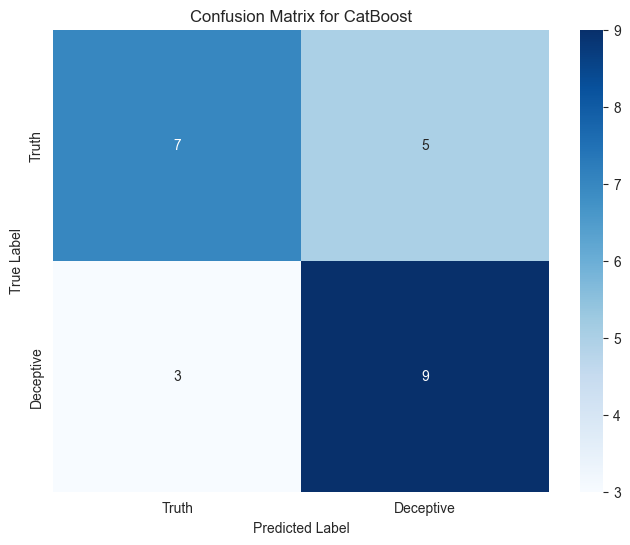

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deceptive'],
            yticklabels=['Truth', 'Deceptive'])
plt.title('Confusion Matrix for CatBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## 6.2 Naive Bayes - only Result

Naive Bayes will use approximately 0s 451ms to do the training with accuracy 0.79 and ROC AUC 0.87. The result is good as the dataset is small and the features joint up with each other not very much.

In [19]:
_, _, _ = fit_and_evaluate(
    use_stacking=False,
    use_xgboost=False,
    use_lightgbm=False,
    use_catboost=False,
    use_naivebayes=True,
    use_knn_model=False,
    n_jobs=8
)

Using naivebayes
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.92      0.81        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24

ROC AUC: 0.87


## 6.3 KNN-only Result

KNN model is a simple model mainly for diversity. It uses approximately 0s 399ms to do the training with accuracy 0.58 and ROC AUC 0.56. The result is not as good as Naive Bayes, but it's still acceptable.

In [21]:
_, _, _ = fit_and_evaluate(
    use_stacking=False,
    use_xgboost=False,
    use_lightgbm=False,
    use_catboost=False,
    use_naivebayes=False,
    use_knn_model=True,
    n_jobs=8
)

Using knn_model
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.58      0.58      0.58        12

    accuracy                           0.58        24
   macro avg       0.58      0.58      0.58        24
weighted avg       0.58      0.58      0.58        24

ROC AUC: 0.56


## 6.4 Stacking Result

Now, let's stack them altogether! It uses approximately 12s 415ms to do the training with accuracy 0.79 and ROC AUC 0.90. The training process is a big slower, but the result is better than any single model, slightly better than the Naive Bayes model, and significantly better than the other two, showing the power of model stacking.

And from the confusion matrix, we can see that the stacked model provides more even results.

In [25]:
_, _, _ = fit_and_evaluate(
    use_stacking=True,
    use_xgboost=False,
    use_lightgbm=False,
    use_catboost=True,
    use_naivebayes=True,
    use_knn_model=True,
    n_jobs=8
)

Stacking [catboost, naivebayes, knn_model]
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.73      0.92      0.81        12

    accuracy                           0.79        24
   macro avg       0.81      0.79      0.79        24
weighted avg       0.81      0.79      0.79        24

ROC AUC: 0.90


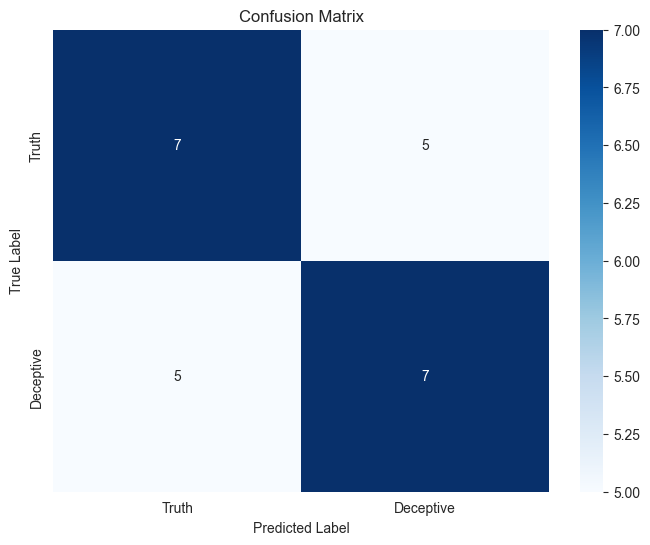

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deceptive'],
            yticklabels=['Truth', 'Deceptive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 7 Conclusions

Your conclusions, suggestions for improvements, etc should go here.

In this project, we have developed and evaluated B-FAUTT (The Boosting-led First-Audio-Then-Text Approach), a multimodal approach for deceptive story detection. Through careful feature engineering and model selection, we have achieved promising results in distinguishing between deceptive and truthful stories, with our best carefully-tuned model achieving an accuracy of 0.79 and ROC AUC of 0.90.

#### Key findings from our work include:

1. Multimodal Advantage: The combination of audio and text features proved more effective than using either modality alone. Features like silence patterns, F-Bank characteristics, and TF-IDF representations together provided a more comprehensive view of deception indicators.

2. Model Architecture: Our stacked ensemble approach, combining CatBoost, Naive Bayes, and KNN models, demonstrated superior performance compared to individual models. The diversity in model architectures helped capture different aspects of deception.

3. Feature Importance: Analysis revealed that certain features were particularly indicative of deception:
    - Audio-based features like silence patterns and voice characteristics
    - Text-based features such as word richness and repetition ratio
    - Combined features linking language choice with audio characteristics

4. Single-Language is Better: Add all-English dataset variant keeps that all samples are compared on a same basis, improve the quality for linguistic features and the overall performance.

#### Suggestions for Future Work:

1. Real-world Application: For practical deployment, considerations should include: Real-time processing capabilities, Model interpretability improvements and Cross-cultural validation.

2. Try with a bigger dataset: A larger dataset would more fully test the model's generalization capabilities and provide more robust insights into deception detection.

# 8 References

Acknowledge others here (books, papers, repositories, libraries, tools)